In [ ]:
import sqlalchemy
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from database_credentials import get_database_url

In [ ]:
stop_words = set(stopwords.words('english'))
plt.style.use('ggplot')

In [ ]:
def check_for_missing_data(data):
    """Print whether or not data contains missing data 
    along with the number of missing entries
    
    Args:
        data (dataframe): dataframe to be checked
        
    Returns:
        None
    """
    
    valid_mask = data.isnull()
    data_contains_missing_values = valid_mask.any().any()
    print("Contains missing values:", data_contains_missing_values)

    if (data_contains_missing_values):
        number_of_missing_values = valid_mask.sum().sum()
        print("Number of missing values:", number_of_missing_values)
    
def check_for_duplicate_ids(data):
    """Print whether or not data contains duplicate 
    Steam IDs along with the number of duplicates
    
    Args:
        data (dataframe): dataframe to be checked
        
    Returns:
        None
    """
    
    unique_id_mask = data['steam_id'].duplicated()
    data_contains_duplicates = unique_id_mask.any()
    print("\nContains duplicate Steam IDs:", data_contains_duplicates)

    if (data_contains_duplicates):
        number_of_duplicates = len(data[unique_id_mask])
        print("Number of duplicate Steam IDs:", number_of_duplicates)
        
def display_info(data):
    """Display the column names, number of rows, and information 
    regarding missing or duplicate values for a dataframe
    
    Args:
        data (dataframe): dataframe for which information will
                          be displayed
    Returns:
        None
    """
    
    print("Column Name and Types:\n{0}\n".format(data.dtypes))
    print("Number of rows: {0}\n".format(data.shape[0]))
    check_for_missing_data(data)
        
def mask_duplicate_ids(data):
    """Mask rows containing duplicate Steam IDs
    
    Args:
        data (dataframe): dataframe with duplicate Steam IDs

    Returns:
        masked_data (dataframe): a copy of data without duplicate
                                 Steam IDs
    """
    
    duplicate_id_mask = ~data['steam_id'].duplicated()
    masked_data = data[duplicate_id_mask]
    return masked_data

def get_review_rating(review):
    """Get the rating from review if applicable
    
    Args: 
        review (str): Steam review
        
    Returns:
        rating_numerator (float/None): rating within the review
    """
    
    rating_numerator = None
    match = re.search(r'(\d+(\.\d+)?)/10', review)
    if (match):
        rating = match[0]
        split_rating = rating.split('/')
        rating_numerator = float(split_rating[0])
        
    return rating_numerator

def round_rating(rating):
    """Round rating to the nearest integer
    
    Args:
        rating (float): rating to be rounded
        
    Returns:
        rounded_rating (float): rating rounded to nearest integer
    """
    
    rounded_rating = round(rating, 0)
    return rounded_rating

def graph_word_cloud(corpus):
    """Graph a word cloud based on corpus
    
    Args:
        corpus (str): contains the text data
    
    Returns:
        None
    """
    
    word_cloud = WordCloud(
        width=1600, height=800, 
        collocations=False
    ).generate(corpus)
    plt.figure(figsize=(20,20))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
def get_percentage_change(initial_value, final_value):
    change = (initial_value - final_value) / initial_value
    percentage_change = round(change * 100, 2)
    return percentage_change

def filter_tokens(tokens):
    filtered_tokens = [
        t for t in tokens if t not in (stop_words and string.punctuation)
    ]
    return filtered_tokens
    
def preprocess_review(review):
    lower_review = review.lower()
    preprocessed_review = word_tokenize(review.lower(), language='english')
    preprocessed_review = filter_tokens(preprocessed_review)
    return preprocessed_review

def initialize_term_df(vocab_list, label):
    term_df = pd.DataFrame(vocab_list, columns=['term'])
    term_df['label'] = label
    return term_df

In [4]:
# connect to database
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect() 

In [5]:
# load data
review_query = '''
    SELECT 
        steam_id,
        user_review,
        FROM_UNIXTIME(timestamp_updated) AS timestamp_updated,
        recommends_game
    FROM reviews;
'''
review_data = pd.read_sql(review_query, connection)

user_query = '''
    SELECT 
        steam_id,
        CEIL(total_minutes_played / 60) AS total_hours_played,
        FROM_UNIXTIME(timestamp_last_played) AS timestamp_last_played
    FROM users;
'''
user_data = pd.read_sql(user_query, connection)

I first start by getting an overview for the review and user data.

In [6]:
display(review_data.head(3))
display_info(review_data)
check_for_duplicate_ids(review_data)

,steam_id,user_review,timestamp_updated,recommends_game
0,76561198109804262,The Game is smooth with great graphics. It sho...,2015-01-14 08:40:12,1
1,76561198144109929,AMAZING Best thing ever. Great graphics for a ...,2015-01-14 06:02:29,1
2,76561198074106169,Best f2p game out there,2015-01-14 03:20:10,1


Column Name and Types:
steam_id                     object
user_review                  object
timestamp_updated    datetime64[ns]
recommends_game               int64
dtype: object

Number of rows: 149999

Contains missing values: False

Contains duplicate Steam IDs: True
Number of duplicate Steam IDs: 3


In [7]:
display(user_data.head(3))
display_info(user_data)
check_for_duplicate_ids(review_data)

,steam_id,total_hours_played,timestamp_last_played
0,76561198109804262,1007,2019-05-07 04:44:48
1,76561198144109929,157,2020-01-07 19:00:17
2,76561198074106169,238,2019-10-25 14:07:33


Column Name and Types:
steam_id                         object
total_hours_played                int64
timestamp_last_played    datetime64[ns]
dtype: object

Number of rows: 149999

Contains missing values: False

Contains duplicate Steam IDs: True
Number of duplicate Steam IDs: 3


Then get rid of duplicate Steam IDs using boolean masks and visualize the review data through a word cloud.

In [8]:
review_data = mask_duplicate_ids(review_data)
user_data = mask_duplicate_ids(user_data)

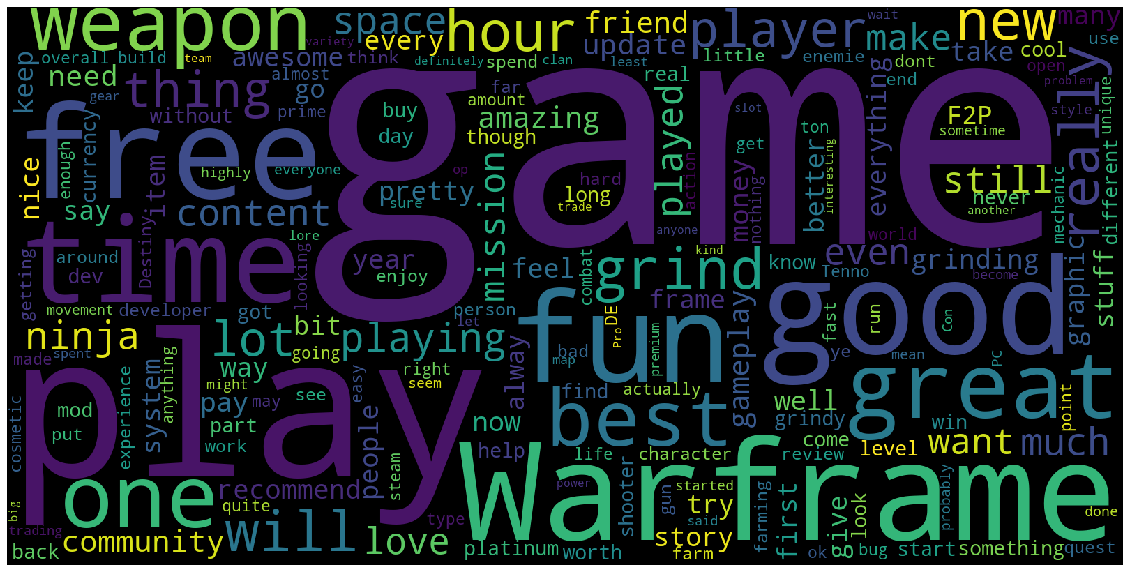

In [9]:
corpus_string = ' '.join(
    review_data.loc[review_data['recommends_game'] == True, 'user_review']
)
graph_word_cloud(corpus_string)

Moving on, I extract ratings (out of 10) from player reviews and discard those greater than 12. This retains 96% of the ratings while dealing with sparser and more extreme ratings.

In [10]:
ratings = review_data['user_review'].apply(get_review_rating)
ratings = ratings.dropna()
trimmed_ratings = ratings[ratings < 13]

In [11]:
number_ratings_initial = ratings.shape[0]
number_ratings_final = trimmed_ratings.shape[0]
percentage_ratings_trimmed = get_percentage_change(
    number_ratings_initial,
    number_ratings_final
)

print("Ratings before trimming:", number_ratings_initial)
print("Ratings after trimming:", number_ratings_final)
print("Percentage of ratings trimmed:", percentage_ratings_trimmed)

Ratings before trimming: 10357
Ratings after trimming: 9953
Percentage of ratings trimmed: 3.9


Display the review containing the most extreme outlier

In [12]:
outlier_index = ratings[np.isinf(ratings)].index[0]
review_data.loc[outlier_index, 'user_review']

'Best Game I have Played 2SPOOKY4ME 99999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999/10'

I then use the ratings as they are to create a violinplot and round the ratings to reduce the number of bins within the countplot.

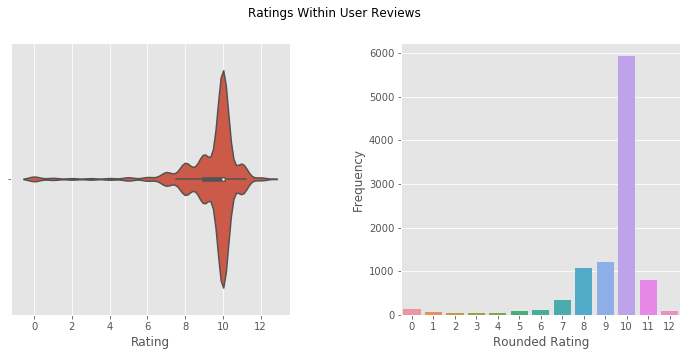

In [13]:
fig, axes = plt.subplots(
    nrows=1, 
    ncols=2, 
    figsize=(12, 5), 
    squeeze=False
)
plt.subplots_adjust(wspace=0.4)
axes = axes.flatten()

rating_violin = sns.violinplot(
    x=trimmed_ratings, 
    ax=axes[0]
)
rating_violin.set(xlabel='Rating')

rounded_ratings = trimmed_ratings.apply(round_rating)
rating_bar = sns.countplot(
    x=rounded_ratings.astype(int),
    ax=axes[1]
)
rating_bar.set(xlabel='Rounded Rating', ylabel='Frequency')
plt.suptitle('Ratings Within User Reviews')
plt.show()

The violin plot determines ratings outside of the approximate interval [7, 11] as outliers
and shows the median of the ratings to be 10. Both the violin and bar plot show that the rating 10/10 appears most frequently and that ratings tend to be higher.
<br>
<br>
Preprocessing reviews by converting to lowercase, along with removing stopwords and punctuation.

In [14]:
review_data['preprocessed_review'] = (
    review_data['user_review'].apply(preprocess_review)
)

In [15]:
preprocessed_corpus = [
    ' '.join(review) for review in review_data['preprocessed_review']
]

In [29]:
instance_names = ['Fortuna', 'Vallis', 'Cetus', 'Plains', 'dojo', 'relay']
instances = initialize_term_df(instance_names, 'instance')

warframe_names = [
    'Ash', 'Atlas', 'Banshee', 'Baruuk', 'Chroma', 'Ember', 'Equinox',
    'Excalibur', 'Frost', 'Gara', 'Garuda', 'Gauss', 'Grendel', 'Harrow',
    'Hildryn', 'Hydroid', 'Inaros', 'Ivara', 'Khora', 'Limbo', 'Loki',
    'Mag', 'Mesa', 'Mirage', 'Nekros', 'Nezha', 'Nidus', 'Nova', 'Nyx',
    'Oberon', 'Octavia', 'Revenant', 'Rhino', 'Saryn', 'Titania', 'Trinity',
    'Valkyr', 'Vauban', 'Volt', 'Wisp', 'Wukong', 'Zephyr'
]
warframes = initialize_term_df(warframe_names, 'warframe')

enemy_names = ['Corpus', 'Grineer', 'Infested']
enemies = initialize_term_df(enemy_names, 'enemy')

npc_names = ['Lotus', 'Clem', 'Baro']
npcs = initialize_term_df(npc_names, 'npc')

# mission locations on the star chart
location_names = [
    'Mercury', 'Venus', 'Earth', 'Mars', 'Phobos',  
    'Ceres', 'Void', 'Jupiter', 'Saturn', 'Europa', 
    'Uranus', 'Neptune', 'Pluto', 'Sedna', 'Derelict'
]
locations = initialize_term_df(location_names, 'location')

terms = [instances, warframes, enemies, npcs, locations]
term_data = pd.concat(terms)
term_data.reset_index(drop=True, inplace=True)

In [30]:
vocab = term_data['term'].str.lower()
pipe = Pipeline(
    [('count', CountVectorizer(vocabulary=vocab)),
     ('tfidf', TfidfTransformer())]
).fit(preprocessed_corpus)
X = pipe['count'].transform(preprocessed_corpus)
count_array = pd.DataFrame(X.toarray())
term_data['frequency'] = count_array.sum()
term_data['tfidf_score'] = pipe['tfidf'].idf_

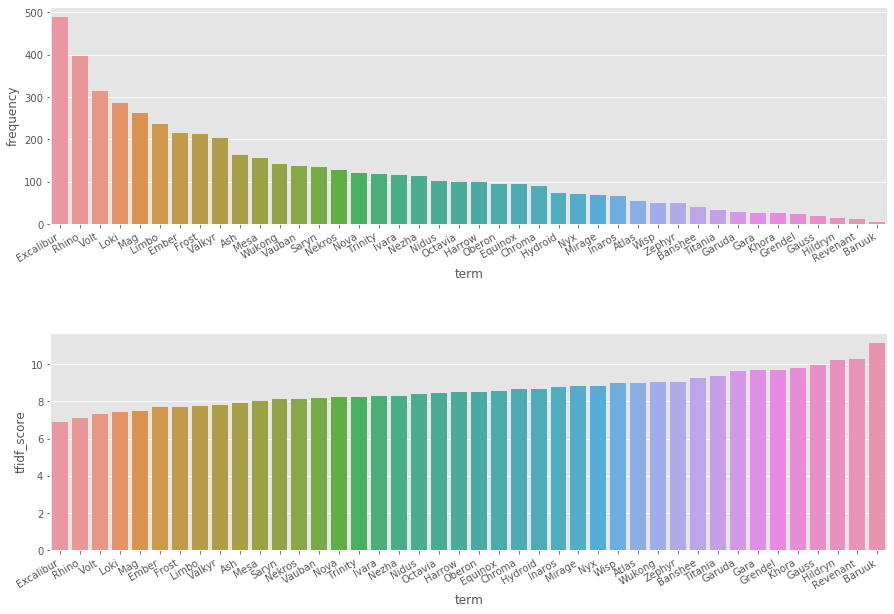

In [31]:
warframe_name_data = term_data[term_data['label'] == "warframe"]
warframe_name_sorted_frequency = (
    warframe_name_data.sort_values('frequency', ascending=False)
)
warframe_name_sorted_tfidf = (
    warframe_name_data.sort_values('tfidf_score', ascending=True)
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

axes = axes.flatten()
for axis in axes:
    plt.setp(axis.get_xticklabels(), rotation=30, ha="right")
    
warframe_frequency_bar = sns.barplot(
    x='term',
    y='frequency',
    data=warframe_name_sorted_frequency, ax=axes[0]
)
warframe_tfidf_bar = sns.barplot(
    x='term', 
    y='tfidf_score', 
    data=warframe_name_sorted_tfidf, 
    ax=axes[1]
)
plt.show()

After visualizing the results, we can see that the ranking for the first 5 and last 4 warframes are the same regardless of whether or not the count or tfidf score is used. On a side note, my favourite warframe Loki is ranked 4th. 

In [33]:
for label in term_data['label'].unique():
    label_data = term_data[term_data['label'] == label]
    label_row = label_data['tfidf_score'].idxmin()
    print("{0}: {1}".format(label, label_data.loc[label_row, 'term']))

instance: Fortuna
warframe: Excalibur
enemy: Grineer
npc: Clem
location: Void


In [ ]:
#connection.close()
#engine.dispose()